In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import pandas as pd
from statsmodels.graphics.api import qqplot

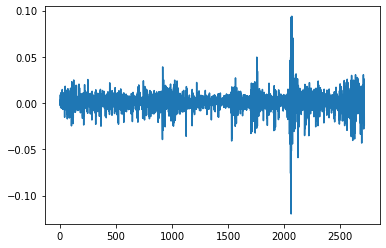

In [97]:
data = pd.read_csv("SP500.csv")
data = data[::-1]
data.reset_index(drop=True, inplace=True)
data.columns = ['Date', 'Open', 'High', 'Low', 'Close']
data['Date'] = pd.to_datetime(data['Date'])
data['Return'] = data['Close'].pct_change()
data.dropna(inplace=True)
data['Return'].plot()

In [99]:
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']
data.drop('Date',axis=1,inplace=True)
data.head()

,Open,High,Low,Close,Return
Date,,,,,
2012-01-04,1277.03,1278.73,1268.10,1277.30,0.000188
2012-01-05,1277.30,1283.05,1265.26,1281.06,0.002944
2012-01-06,1280.93,1281.84,1273.34,1277.81,-0.002537
2012-01-09,1277.83,1281.99,1274.55,1280.70,0.002262
2012-01-10,1280.77,1296.46,1280.77,1292.08,0.008886


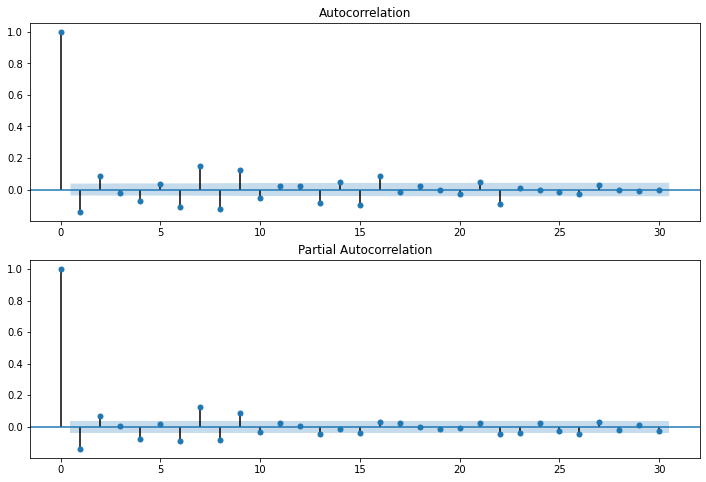

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.Return.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.Return, lags=30, ax=ax2)
plt.show()

In [55]:
# chose p appropriately
p = 1

arma_mod = sm.tsa.ARIMA(data.Return, order=(p,0,0)).fit()
print(arma_mod.params)

if p==1:
    rho = np.array([0, arma_mod.params[0]/(1-arma_mod.params[1]), 
                    arma_mod.params[0]**2/(1-arma_mod.params[1])+arma_mod.params[1]])arma_mod.params[2]

roots = np.roots([-arma_mod.params[1], -arma_mod.params[0], 1])
print('roots: ', roots)

const           0.000439
ar.L1.Return   -0.140296
dtype: float64
roots:  [0.00156576+2.66979493j 0.00156576-2.66979493j]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Prediction

In [65]:
tsteps = .1

# fig, ax = plt.subplots(figsize=(12, 8))
# ax = data.loc['2020':].plot(ax=ax)
T = np.arange(2020, 2024, tsteps)
for tt in range(len(T)-1):
    pred = arma_mod.predict(str(T[tt]), str(T[tt+1]), plot_insample=False)
    pred.plot()
plt.show()

TypeError: ignored

Not working yet... switching to auto_arima...

In [72]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 9.9 MB 34.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [73]:
from pmdarima.arima import auto_arima

In [100]:
model_train = data.iloc[:int(data.shape[0]*0.8)]
valid = data.iloc[int(data.shape[0]*0.8):]
y_pred = valid.copy()

In [101]:
model_arima = auto_arima(model_train["Close"], trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
              suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Close"])

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20254.946, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20185.118, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20139.828, Time=0.75 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=20140.685, Time=1.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20167.769, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20158.266, Time=1.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20141.192, Time=1.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=20139.984, Time=2.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20148.327, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20148.040, Time=1.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20138.694, Time=4.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20137.247, Time=3.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=20143.956, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=20058.500, Time=2.85 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20018.995, Time=4.30

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [102]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


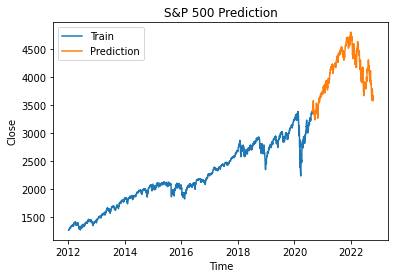

In [112]:
plt.plot(model_train.index, model_train.Close, label='Train')
plt.plot(valid.index, valid.Close, label="Prediction")
# plt.plot(valid.index, y_pred["ARIMA Model Prediction"], label="Prediction")
plt.title("S&P 500 Prediction")
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend(loc='upper left')
plt.show()